In [1]:
# Scope: inglobe notebooks `test.ipynb`, `prove.ipynb`, `dataset_cleaning.ipynb`

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Dataset Loading
Let's start by studying the quality of our dataset, and investigating some statistics. 

The data was taken from [Kaggle](https://www.kaggle.com/datasets/snehallokesh31096/recipe/data).

In [3]:
df = pd.read_csv('./dataset/recipes_82k.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82245 entries, 0 to 82244
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   category        18107 non-null  object
 1   cooking_method  82245 non-null  object
 2   cuisine         82230 non-null  object
 3   image           82245 non-null  object
 4   ingredients     82245 non-null  object
 5   prep_time       58630 non-null  object
 6   recipe_name     82245 non-null  object
 7   serves          82244 non-null  object
 8   tags            82011 non-null  object
dtypes: object(9)
memory usage: 5.6+ MB


In [5]:
# Drop the columns that are not useful for the analysis
df.drop(columns=['category', 'cuisine', 'image', 'prep_time', 'recipe_name', 'serves'], inplace=True)

Since we will focus on the recipe, column `cooking_method`, we drop the null values for this feature.

In [6]:
# Drop the rows with missing values in cooking_method
df.dropna(subset=['cooking_method'], inplace=True)
df = df[df['cooking_method'] != '[]']
df.dropna(subset=['tags'], inplace=True)

df.reset_index(drop=True, inplace=True)

In [7]:
df.head()

,cooking_method,ingredients,tags
0,['Set the racks in the middle and upper thirds...,"['1 tablespoons extra virgin olive oil', '1 cu...","Dairy Free, Gluten Free, Keto Recipes, Kid Fri..."
1,['Place the eggs in the air fryer basket and c...,"['4 large eggs', 'Salt (black pepper, everythi...","Air Fryer Recipes, Dairy Free, Gluten Free, Ke..."
2,"['Air Fryer directions:', 'Preheat air fryer t...","['olive oil spray', '4 about 5 ounce each salm...","Air Fryer Recipes, Gluten Free, Keto Recipes, ..."
3,"['Preheat the oven to 400F.', 'Pour 2 tablespo...",['1/2 cup freshly grated Parmesan (not pre-gra...,"Gluten Free, Keto Recipes, Kid Friendly, Low C..."
4,['Cook potatoes in a large pot of salted water...,['3 1/2 pounds new potatoes (about 10 peeled a...,"Dairy Free, Gluten Free, Kid Friendly, Vegetar..."


### Defrivation of the vocabulary for the whole corpus
Our corpus consists of the totality of the recipes, i.e., the whole `cooking_method` column. In the following cell we process this data t generate a vocabulary out of this corpus.

In [8]:
cooking_method = df['cooking_method']
type(cooking_method)

pandas.core.series.Series

In [9]:
def make_vocabulary(df):
    cooking_method = df['cooking_method']
    cooking_method = cooking_method.str.lower()
    cooking_method = cooking_method.str.replace('-', '') # fluffy-light -> fluffylight
    # remove all numbers and punctuations 
    cooking_method = cooking_method.str.replace(r'[^a-z\s]', ' ', regex=True)
    # remove multiple spaces
    cooking_method = cooking_method.str.replace(r'\s+', ' ')
    cooking_method = cooking_method.str.split()
    # remove duplicates (making it a set) and make it a list
    cooking_method = cooking_method.apply(lambda x: list(set(x)))
    cooking_method = cooking_method.explode() 
    
    cooking_method = cooking_method.value_counts()
    return cooking_method

In [10]:
cooking_method = make_vocabulary(df)
len(cooking_method)

24811

## Average length of recipes and ingredient list

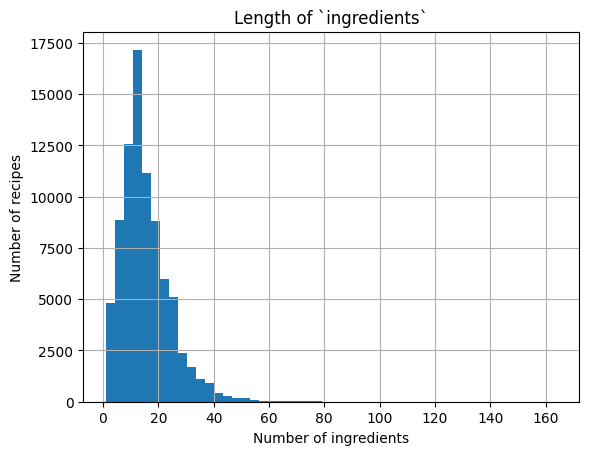

In [11]:
# histogram of length of ingredients
df['ingredients'].apply(lambda x: len(x.split(','))).hist(bins=50)
plt.xlabel('Number of ingredients')
plt.ylabel('Number of recipes')
plt.title('Length of `ingredients`')
plt.show()

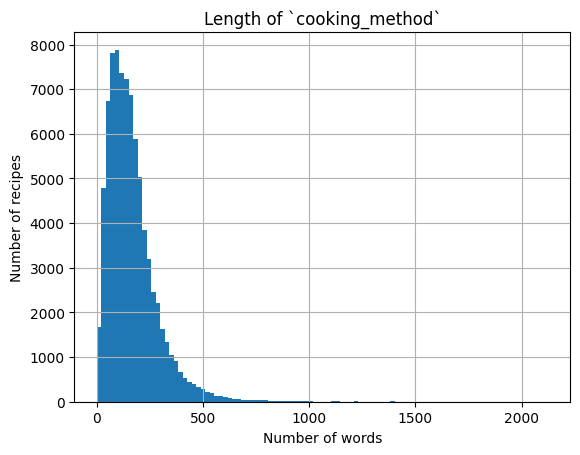

In [12]:
# same for cooking_method
df['cooking_method'].apply(lambda x: len(x.split(' '))).hist(bins=100)
plt.xlabel('Number of words')
plt.ylabel('Number of recipes')
plt.title('Length of `cooking_method`')
plt.show()

## Distribution of tags

In [13]:
df.head()

,cooking_method,ingredients,tags
0,['Set the racks in the middle and upper thirds...,"['1 tablespoons extra virgin olive oil', '1 cu...","Dairy Free, Gluten Free, Keto Recipes, Kid Fri..."
1,['Place the eggs in the air fryer basket and c...,"['4 large eggs', 'Salt (black pepper, everythi...","Air Fryer Recipes, Dairy Free, Gluten Free, Ke..."
2,"['Air Fryer directions:', 'Preheat air fryer t...","['olive oil spray', '4 about 5 ounce each salm...","Air Fryer Recipes, Gluten Free, Keto Recipes, ..."
3,"['Preheat the oven to 400F.', 'Pour 2 tablespo...",['1/2 cup freshly grated Parmesan (not pre-gra...,"Gluten Free, Keto Recipes, Kid Friendly, Low C..."
4,['Cook potatoes in a large pot of salted water...,['3 1/2 pounds new potatoes (about 10 peeled a...,"Dairy Free, Gluten Free, Kid Friendly, Vegetar..."


In [14]:
tags = []
for i in range(len(df)):
    ing = (df['tags'][i].split(','))
    # strip the string
    ing = [x.strip() for x in ing]
    tags.append(ing)
tags = pd.Series([item for sublist in tags for item in sublist])
tags = tags.value_counts()
len(tags)

765

765 tags are too many, we want to restrict our classification into few, meaningful classes. Our primary idea was to classify the tags `Vegetarian`, `Dairy Free`, `Gluten Free`, `Low Carb`, `Low Fat`, `Low Sodium`. 

To do so we will group all the tags that, if present, will be the ground truth for out label assignment. We will also create some 'macro ingredients' categories that will be usefull later.

In [21]:
vegetarian = [
    'Vegan',
    'Vegetarian',
    'Vegetarian Meals'
]

# regex to match any of the words in vegetarian
regex = '|'.join(vegetarian)

# function to check if a recipe is Vegetarian
def is_vegetarian(tags):
    return int(bool(re.search(regex, tags)))

# define a new column that has value 1 if the tags contains any of the vegetarian tags
df['Vegetarian'] = df['tags'].apply(is_vegetarian)

# define a new column that has value 1 if the tags contains 'Dairy Free'
df['Dairy Free'] = df['tags'].str.contains('Dairy Free').astype(int)

# define a new column that has value 1 if the tags contains 'Gluten Free'
df['Gluten Free'] = df['tags'].str.contains('Gluten Free').astype(int)

# define a new column that has value 1 if the tags contains 'Low Carb' or 'Low-Carb'
df['Low Carb'] = df['tags'].str.contains('Low Carb|Low-Carb').astype(int)

# define a new column that has value 1 if the tags contains 'Low Fat'
df['Low Fat'] = df['tags'].str.contains('Low-Fat').astype(int)

# define a new column that has value 1 if the tags contains 'Low Sodium'
df['Low Sodium'] = df['tags'].str.contains('Low Sodium').astype(int)

In [20]:
from utils.macro_tags import get_meat_tags, get_fish_tags, get_dairy_tags, get_dessert_tags
dessert = get_dessert_tags()
regex_d = '|'.join(dessert)

# function to check if a recipe is Vegetarian
def is_dessert(tags):
    return int(bool(re.search(regex_d, tags)))

# define a new column that has value 1 if the tags contains any of the dessert tags
df['Dessert'] = df['tags'].apply(is_dessert)

In [22]:
#the same for meat, fish and dairy

#meat
meat = get_meat_tags()
regex_m = '|'.join(meat)

def is_meat(tags):
    return int(bool(re.search(regex_m, tags)))

df['Meat'] = df['tags'].apply(is_meat)


#fish
fish = get_fish_tags()
regex_f = '|'.join(fish)

def is_fish(tags):
    return int(bool(re.search(regex_f, tags)))

df['Fish'] = df['tags'].apply(is_fish)


#dairy
dairy = get_dairy_tags()
regex_da = '|'.join(dairy)

def is_dairy(tags):
    return int(bool(re.search(regex_da, tags)))

df['Dairy'] = df['tags'].apply(is_dairy)

df.head()



,cooking_method,ingredients,tags,Vegetarian,Dairy Free,Gluten Free,Low Carb,Low Fat,Low Sodium,Dessert,Meat,Fish,Dairy
0,['Set the racks in the middle and upper thirds...,"['1 tablespoons extra virgin olive oil', '1 cu...","Dairy Free, Gluten Free, Keto Recipes, Kid Fri...",0,1,1,1,0,0,0,0,0,0
1,['Place the eggs in the air fryer basket and c...,"['4 large eggs', 'Salt (black pepper, everythi...","Air Fryer Recipes, Dairy Free, Gluten Free, Ke...",1,1,1,1,0,0,0,0,0,0
2,"['Air Fryer directions:', 'Preheat air fryer t...","['olive oil spray', '4 about 5 ounce each salm...","Air Fryer Recipes, Gluten Free, Keto Recipes, ...",0,0,1,1,0,0,0,0,0,0
3,"['Preheat the oven to 400F.', 'Pour 2 tablespo...",['1/2 cup freshly grated Parmesan (not pre-gra...,"Gluten Free, Keto Recipes, Kid Friendly, Low C...",1,0,1,1,0,0,0,0,0,0
4,['Cook potatoes in a large pot of salted water...,['3 1/2 pounds new potatoes (about 10 peeled a...,"Dairy Free, Gluten Free, Kid Friendly, Vegetar...",1,1,1,0,0,0,0,0,0,0


Furthermore, since the Dessert are usually vegetarian, we want to merge these 2 tags i a new tag

In [22]:
df['Vegetarian&Dessert'] = df['Vegetarian'] | df['Dessert']

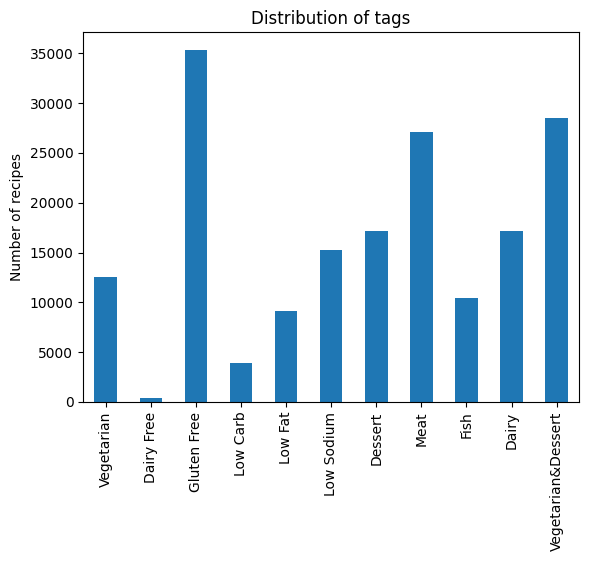

In [23]:
tags = df.columns[3:]
tags_dist = df[tags].sum()
tags_dist.plot(kind='bar')
plt.ylabel('Number of recipes')
plt.title('Distribution of tags')
plt.show()

Now let's see the distribution of some tags.

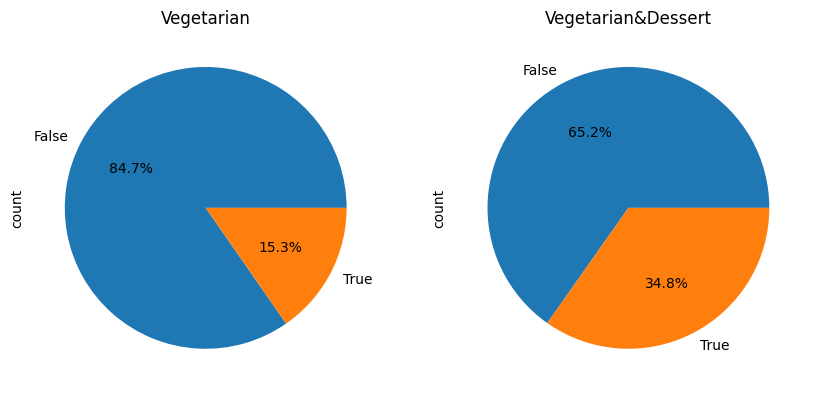

In [27]:
# merge the 2 images above in one
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df['Vegetarian'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
ax[0].set_title('Vegetarian')
df['Vegetarian&Dessert'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
ax[1].set_title('Vegetarian&Dessert')

plt.show()



... Dataset Cleaning e test e prove uniti con successo !!!!!!!!!!!!!!!!!!!

In [ ]:
# TODO: plot bar plot delle tags originali? far vedere qualche esempio sul perché 'vegetable' non implica 'vegetarian' ecc? fare più pie charts?
# dire bene che se non è presente 'Vegetarian' questo non implica che il piatto non sia vegetariano, ma che non è stato etichettato come tale
# però ora abbiamo 'Meat, Fish' che sicuramente escludono vegetariano. Controllare se tags hanno sia Vegetarian che meat? bhooooo

In [ ]:
# TODO: studiare qualita delle ricette predette come veg: magari sono davvero veg anche se il ground truth è 0... il dataset non è perfetto

# Save Cleaned Dataset

In [23]:
len(df)

81957

In [27]:
# save as a csv file
df.to_csv('./dataset/dataset.csv', index=False)